In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Boosting

Early on we looked at one type of ensemble model - bagging, specifically with Forests made from several trees. When bagging we take a bunch of copies of the data, slice it up into random subsets, let each model make predictions, then combine those predictions (via vote/average) into a final answer. Bagging is effective at combatting overfitting, and this is especially visible with those trees since we could see how overfitted a tree model could get if we allowed it to grow large. 

Boosting is another type of ensemble that takes a different approach to combining several models. Boosting is sequential - it takes the results from one model, and uses those results to guide the training of a subsequent model. In order to explain this, we need to first examine one other concept - weak and strong learners. 

## Weak Learners and Strong Learners

We can split predictive models into two classes, depending on their performance:
<ul>
<li> Weak learners - models that perform only slightly better than guessing. 
<li> Strong learners - models that perform "much" better than guessing.
</ul>

We've been looking at strong learners when building models so far - regression, SVM, SGD - all able to achieve a high level of accuracy if we tune them with appropriate hyperparameters, thus all strong learners.

What's a weak learner? The easiest example is a tiny decision tree - if we were to limit the depth to 2 levels - representing one decision. Technically we can create weak learners out of almost any model by tuning them to eliminate variance. Trees are common though. 

### Why Would Anyone Want a Weak Learner?

We generally want accuracy, so conciously moving to a less accurate model seems... odd. Following from the performance of weak and strong learners, we can draw another conclusion that should be intuitive:
<ul>
<li> Weak learners are simple to compute. E.g. a one-decision decision tree is simple. This is also called a stump. 
<li> Strong learners are hard to compute. 
</ul>

The "magic" comes from combining weak learners with the concept of boosting. We can combine many simple and quick weak learning models together through boosting, and acheive an ensemble that can acheive high accuracy, like a strong learner. These boosted ensembles can deliver very good performance in practice, with low amounts of overfitting and high levels of accuracy. We'll look at two examples that are popular - Adaboost and XGboost. 

## Adaboost

Adaboost is short for adaptive boosting, it is one of, if not the, most commonly used boosting algorithms. Adaboost is conceptually fairly simple in how it learns:
<ul>
<li> Generate predictions for the data in the training set with the first model.
    <ul>
    <li> Predictions that were incorrect get their weights increased, so they are selected more often. 
    <li> Predictions that are correct have their weights decreased. 
    </ul>
<li> Pass the data, along with the weights, on to the next model. 
<li> As the predictions are being made, the individual models are also evaluated and weighted. 
    <ul>
    <li> Models that predict correctly get weighted higher. 
    <li> Models that do not predict correctly are weighted lower.  
    </ul>
<li> Repeat until everything is correct, or you've hit the limit. 
<li> Predictions are a weighted sum (using the weights of the models) of the predictions of all the models. 
</ul>

We can think of the process roughly like this:
<ul>
<li> We make predictions with a bunch of quick but simple models, those that are the most accurate have their importance to the final predictions increased. 
<li> We take the data that hasn't been correctly classified, and predict it with more models until we get it correct. All the ones that we've already correctly predicted need less attention. 
</ul>

It is kind of like if you were to look at a room of people, and classify them as either NFL players or gymnasts using some simple tests. First you'd look at weight, that would do a very good job and get a high score as a model. Then you may take the leftover people and split them by height. Then you'd take the rest and split them by net worth.... Eventually you may split them by number of broken bones or something similarly obscure. The models that do the best job of splitting the groups would get the biggest impact on the final classification. The records that are easy to classify would be done immediately with one of the important models, those that are harder would filter through more and more models until they are able to be accurately classified. 

Most examples of boosting look at classification because it is more illustrative. Regression works the same way, we just replace the accuracy rate with a metric like MSE. Accurate predictions are like correct ones, and the most accurate models are promoted in importance. 

### Using Adaboost

Using adabost is pretty similar to using every other model. Adaboost can perform both classification and regression, the mechanics of each rely on the underlying algorithm. That algorithm is normally a decision tree classifier/regressor, but other estimators can be used. 

In [2]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor

In [3]:
df_ada = pd.read_csv("data/titanic_train.csv")
y_ada = df_ada["Survived"]
X_ada = df_ada.drop(columns={"Survived"})
df_ada.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
ada = AdaBoostClassifier()

column_trans = ColumnTransformer([
    ('categories', OneHotEncoder(), ["Sex", "Embarked"]),
    ('title_bow', SimpleImputer(strategy="median"), ["Age", "Pclass", "SibSp", "Parch", "Fare"])
    ],
    remainder='drop'
)

ada_pipe = Pipeline([
    ("ct", column_trans),
    ("ada", ada)
])
Xtr, Xte, ytr, yte = train_test_split(X_ada, y_ada)
ada_pipe.fit(X=Xtr, y=ytr.ravel())

ada_preds = ada_pipe.predict(Xte)
accuracy_score(yte, ada_preds)

0.8116591928251121

#### Exercise

Predict quality. Try swapping some other estimator in the adaboost. If you have extra time, do a grid search for different estimators. 

In [5]:
wine = pd.read_csv("data/WineQT.csv")
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [6]:
y_wine = wine["quality"]
X_wine = wine.drop(columns={"Id", "quality"})
X_wine_tr, X_wine_te, y_wine_tr, y_wine_te = train_test_split(X_wine, y_wine)

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR

#Try with different estimator
test_est = LinearRegression()
#test_est = LinearSVR(max_iter=10000)
wine_ada = AdaBoostRegressor(base_estimator=test_est, n_estimators=100, learning_rate=.1)
#wine_ada = AdaBoostRegressor()

wine_ada_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("ada", wine_ada)
])

wine_ada_pipe.fit(X=X_wine_tr, y=y_wine_tr.ravel())

wine_ada_preds = wine_ada_pipe.predict(X_wine_te)
mean_squared_error(wine_ada_preds, y_wine_te, squared=False)

0.6785959744927623

## XGboost and Gradient Boosting

XGboost is short for extreme gradient boosting, a new and ofter very accurate ensemble method. 

#### Installing XGboost

XGboost isn't part of SK Learn, we have to install it. The package name is xgboost and it can be installed through whatever means works on your computer:
<ul>
<li> pip install xgboost
<li> conda install -c conda-forge xgboost
<li> conda gui installation, if it is available there. 
</ul>

I installed it via pip, and got weird errors (kernel died) when using it. Running:

conda install -c conda-forge xgboost

did fix it. 

There are dependencies, so the process may require installing other items to make it work. On my work Mac, after installing XGboost, I got an error and had to install another library with the command: "brew install libomp". This command was given to me by the error message when I tried to import xgboost in code. Based on past experience, there may be some variety 

Install documentation is here: https://xgboost.readthedocs.io/en/stable/install.html

### Gradient Boosting

Before we can get eXtreme!!!!! with xgboost, we need to look at one of it's main component parts - gradient boosting. Gradient boosting is another type of boosting, similar to Adabost, however with gradient boosting the subsequent models are trained on the residual error of the previous model. 

The big difference is that gradient boosting is trained on the residual errors and this is the factor that increases importance for the next training. In Adaboost the high weight records are given more importance, in gradient boosting the higher gradients are given more importance. 

The process that gradient boosting uses is:
<ul>
<li> Make an initial set of predictions - this is often done by just making a generic prediction for all records, such as the average. This will generate residuals, or more generally, some measure of loss defined by the loss function. These residuals are the starting point. 
<li> Fit a weak learner with the feature set and the residuals of the previous round. In gradient boosting the weak learners (normally trees) tend to be larger - 8 to 32 nodes. 
<li> Repeat the previous step repeatedly until the limit of number of estimators is reached. 
<li> Predictions are the initial prediction, plus all of the residual predictions averaged together (scaled by the learning rate). This is called shrinkage. 
    <ul>
    <li> y(pred) = y1 + (eta *  r1) + (eta * r2) + ....... + (eta * rN)
    </ul>
</ul>

![Gradient](images/gradientboosting.png "Gradient" )

Gradient boosting also works for regression and classification. With the algorithm here it is easier to think of as a regression problem since it is based on residuals. When used for classification the algorithm uses the sigmoid to translate to classification, just as logistic regression does. 

For the most part the parameters for gradient boosting are ones that we are familiar with - error metrics, learning rate, tree options (#leafs etc...), and the number of estimators used. Gradient boosting is typically fairly resistant to overfitting, so a large number of estimators will often be better. 

In [8]:
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [9]:
df_gb = pd.read_csv("data/bodyfat.csv")
y_gbr = df_gb["BodyFat"]
X_gbr = df_gb.drop(columns={"BodyFat"})
df_gb.head()

,Density,BodyFat,Age,Weight,Height,Neck,Chest,Abdomen,Hip,Thigh,Knee,Ankle,Biceps,Forearm,Wrist
0,1.0708,12.3,23,154.25,67.75,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.1
1,1.0853,6.1,22,173.25,72.25,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.2
2,1.0414,25.3,22,154.00,66.25,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.6
3,1.0751,10.4,26,184.75,72.25,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.2
4,1.0340,28.7,24,184.25,71.25,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.7


In [10]:
gbr = GradientBoostingRegressor()
gbr_pipe = Pipeline([
    ("scale", MinMaxScaler()),
    ("gbc", gbr)
])

Xtr_r, Xte_r, ytr_r, yte_r = train_test_split(X_gbr, y_gbr)
gbr_pipe.fit(X=Xtr_r, y=ytr_r.ravel())

gbr_preds = gbr_pipe.predict(Xte_r)
mean_squared_error(yte_r, gbr_preds, squared=False)

1.721537410907562

### Exercise

Use the classifier version of gradient boosting to predict titanic survival. 

#### HistGradientBoosting

SKlearn also provides a package called HistGradientBoosting which is inspired by LightGBM. It can be much faster when datasets get large and has the side benefit of automatically handling missing values. Try with this one if you have a moment, details for the classifier are: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html The underlying change is that these algorithms bin (discreetize) the data up front, which reduces the number of splits and allows the math to be done on integers, which is faster. HGB also defaults to utilizing early stopping to speed processing. 

In [11]:
titan_gb_mod = GradientBoostingClassifier()

titan_gb_ct = ColumnTransformer([
    ('categories', OneHotEncoder(), ["Sex", "Embarked"]),
    ('title_bow', SimpleImputer(strategy="median"), ["Age", "Pclass", "SibSp", "Parch", "Fare"])
    ],
    remainder='drop'
)

titan_gb_pipe = Pipeline([
    ("ct", titan_gb_ct),
    ("model", titan_gb_mod)
])

titan_gb_pipe.fit(X=Xtr, y=ytr.ravel())

titan_gb_preds = titan_gb_pipe.predict(Xte)
accuracy_score(yte, titan_gb_preds)

0.8340807174887892

#### Gradient Boosting Classification and Stochastic Gradient Boosting

Using gradient boosting for classification is similar. One additional hyperparameter we can utilize here is "subsample", which controls the fraction of records used for each learner. Setting this to be less than 1 causes the algorithm to use stochastic gradient boosting - utilizing a randomized subset of the data for each tree. This tends to protect against overfitting, similarly to how it works in a forest model. If the dataset is large, this can also speed things up. A split of 30% to 70% is pretty typical to try, typically towards the lower-middle of that range. 

In [12]:
gbc = GradientBoostingClassifier(subsample=.3)

column_trans2 = ColumnTransformer([
    ('categories', OneHotEncoder(), ["Sex", "Embarked"]),
    ('title_bow', SimpleImputer(strategy="median"), ["Age", "Pclass", "SibSp", "Parch", "Fare"])
    ],
    remainder='drop'
)

gbc_pipe = Pipeline([
    ("ct", column_trans2),
    ("gbc", gbc)
])

Xtr, Xte, ytr, yte = train_test_split(X_ada, y_ada)
gbc_pipe.fit(X=Xtr, y=ytr.ravel())

gbc_preds = gbc_pipe.predict(Xte)
accuracy_score(yte, gbc_preds)

0.7892376681614349

### XGboost

Ok, now we're ready to be eXtreme!!!! and use xgboost. XGboost is basically an implementation of gradient boosting that adds in many of the concpets that we've previously touched on to improve its speed, accuracy, and resiliance to overfitting - thus making it eXtreme!!! Some of the things xgboost incorporates are:

<ul>
<li> Parallelization - boosting is generally a sequential process, so it is hard to run in parallel. Xgboost is carefully written to allow the parts that can be run in parallel, to be run in parallel. This makes xgboost faster than it would be with a traditional boosted implementation. 
<li> Cross validation - xgboost builds in cross-validation as part of it's standard execution. 
<li> Regularization - xgboost applies regularization (L1 or L2) to limit overfitting. 
<li> Sparse and missing data handling - xgboost smartly deals with data that has missing values, or data that is sparse. 
<li> Optimization - xgboost is written to utilize hardware resources very efficiently, including both processing power and memory limits. 
</ul>

In short, xgboost is effectively a compilation of many of the tools that we've looked at to build better models, all wrapped into one simple package. Outside of neural networks with very large datasets, xgboost is generally the most likely algorithm to be the "best", both in terms of accuracy and speed. This isn't universal, of course, different data will perform differently with different algorithms, but xgboost is likely to be a winner, probably more than any other algorithm. 

In [13]:
import xgboost as xgb

#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

#### XGboost and eXtreme!!! Speed

One of the benefits of xgboost is that it is fast. The 70,000 digit images was very slow to process in past attempts with other algorithms, to the point that we cut it down to 10,000 or so to make the time manageable. We can see what xgboost can do for us with the full 70,000 images along with a very gentle PCA that should keep the vast majority of the varaiance. Recall we had a 150 component PCA that only slightly blurred the images. 

Some parameters that we may want to look at for xbgoost are:
<ul>
<li> booster: can be changed to gblinear to swap the default tree models to linear ones. 
<li> max_depth: same as in trees. 
<li> lambda/alpha: L2 and L1 regularization strength, respectively. 
<li> eta: amount of pruning. 
</ul>
The full set is well documented, and fairly easy to understand, located: https://xgboost.readthedocs.io/en/stable/parameter.html 

Note: xgboost defaults to creating the maximal number of threads, similar to doing n_jobs=-1 for things like a forest. 

In [15]:
model = xgb.XGBClassifier(max_depth=2)

pipeline = Pipeline([
    #('standard_scaler', StandardScaler()), 
    ('pca', PCA(200)), 
    ('model', model)
])

pipeline.fit(X_train, y_train)
xgb_preds = pipeline.predict(X_test)


C:\Users\soniy\anaconda3\envs\tmp_test\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:59:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.9248


<AxesSubplot:>

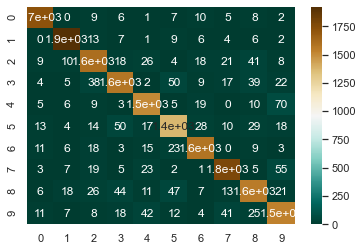

In [16]:
print(accuracy_score(y_test, xgb_preds))
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, cmap="BrBG_r")

Wow, that's... <h1>eXtreme!!!!!!!!!!!!!!!</h1> We can process the whole set of 70,000 in a reasonable amount of time, at a high accuracy. XGboost is currently the overall "king" of the non-neural network algorithms for most problems. 

### Exercise

Predict the categories of the newsgroups. 

In [17]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

In [18]:
remove = ("headers", "footers", "quotes")

data_train = fetch_20newsgroups(
    subset="train", shuffle=True, remove=remove)

data_test = fetch_20newsgroups(
    subset="test", shuffle=True, remove=remove)

In [19]:
news_tf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,3), stop_words="english", strip_accents="unicode")
X_train = news_tf.fit_transform(data_train.data)
y_train = data_train.target
X_test = news_tf.transform(data_test.data)
y_test = data_test.target
print("Train (x,y):", X_train.shape, "  Test (x,y):", X_test.shape)

Train (x,y): (11314, 1971374)   Test (x,y): (7532, 1971374)


In [20]:
# Create Models
tsvd = TruncatedSVD(n_components=100)
model = xgb.XGBClassifier(max_depth=2)

news_steps = [
    ('svd', tsvd),
    ('m', model)
    ]
    
news_model = Pipeline(steps=news_steps)
news_model.fit(X_train, y_train)
news_preds = news_model.predict(X_test)


C:\Users\soniy\anaconda3\envs\tmp_test\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:04:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.588688263409453


<AxesSubplot:>

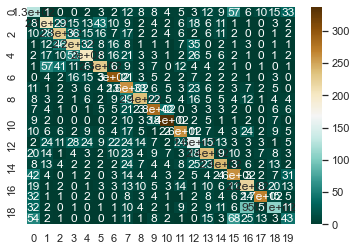

In [21]:
print(accuracy_score(y_test, news_preds))
sns.heatmap(confusion_matrix(y_test, news_preds), annot=True, cmap="BrBG_r")